In [1]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.integrate import solve_ivp
import scipy.stats as stats
import pandas as pd

%matplotlib inline
plt.rcParams['figure.dpi'] = 130
# plt.rcParams['savefig.dpi'] = 300

# Reaction Analysis in Batch and Continuous Flow Reactors
https://doi.org/10.1002/kin.20597

https://doi.org/10.1016/j.cep.2006.02.010 

Using the following soponification reaction as our experimental model
$${NaOH} + {EtOAc} \longrightarrow {NaOAC} + {EtOH}$$
$${A} + {B} \longrightarrow {C} + {D}$$

## Batch Reactor

For the batch reaction, we operated under the following conditions:

$T_{Bath} = (25 °C, 30 °C, 35 °C)$

$C_{NaOH,0} \approx 0.05 mol/dm^3$

$C_{EtOAC,0} \approx 0.05 mol/dm^3$

### 1) Deriving differential batch design equation from mole balance

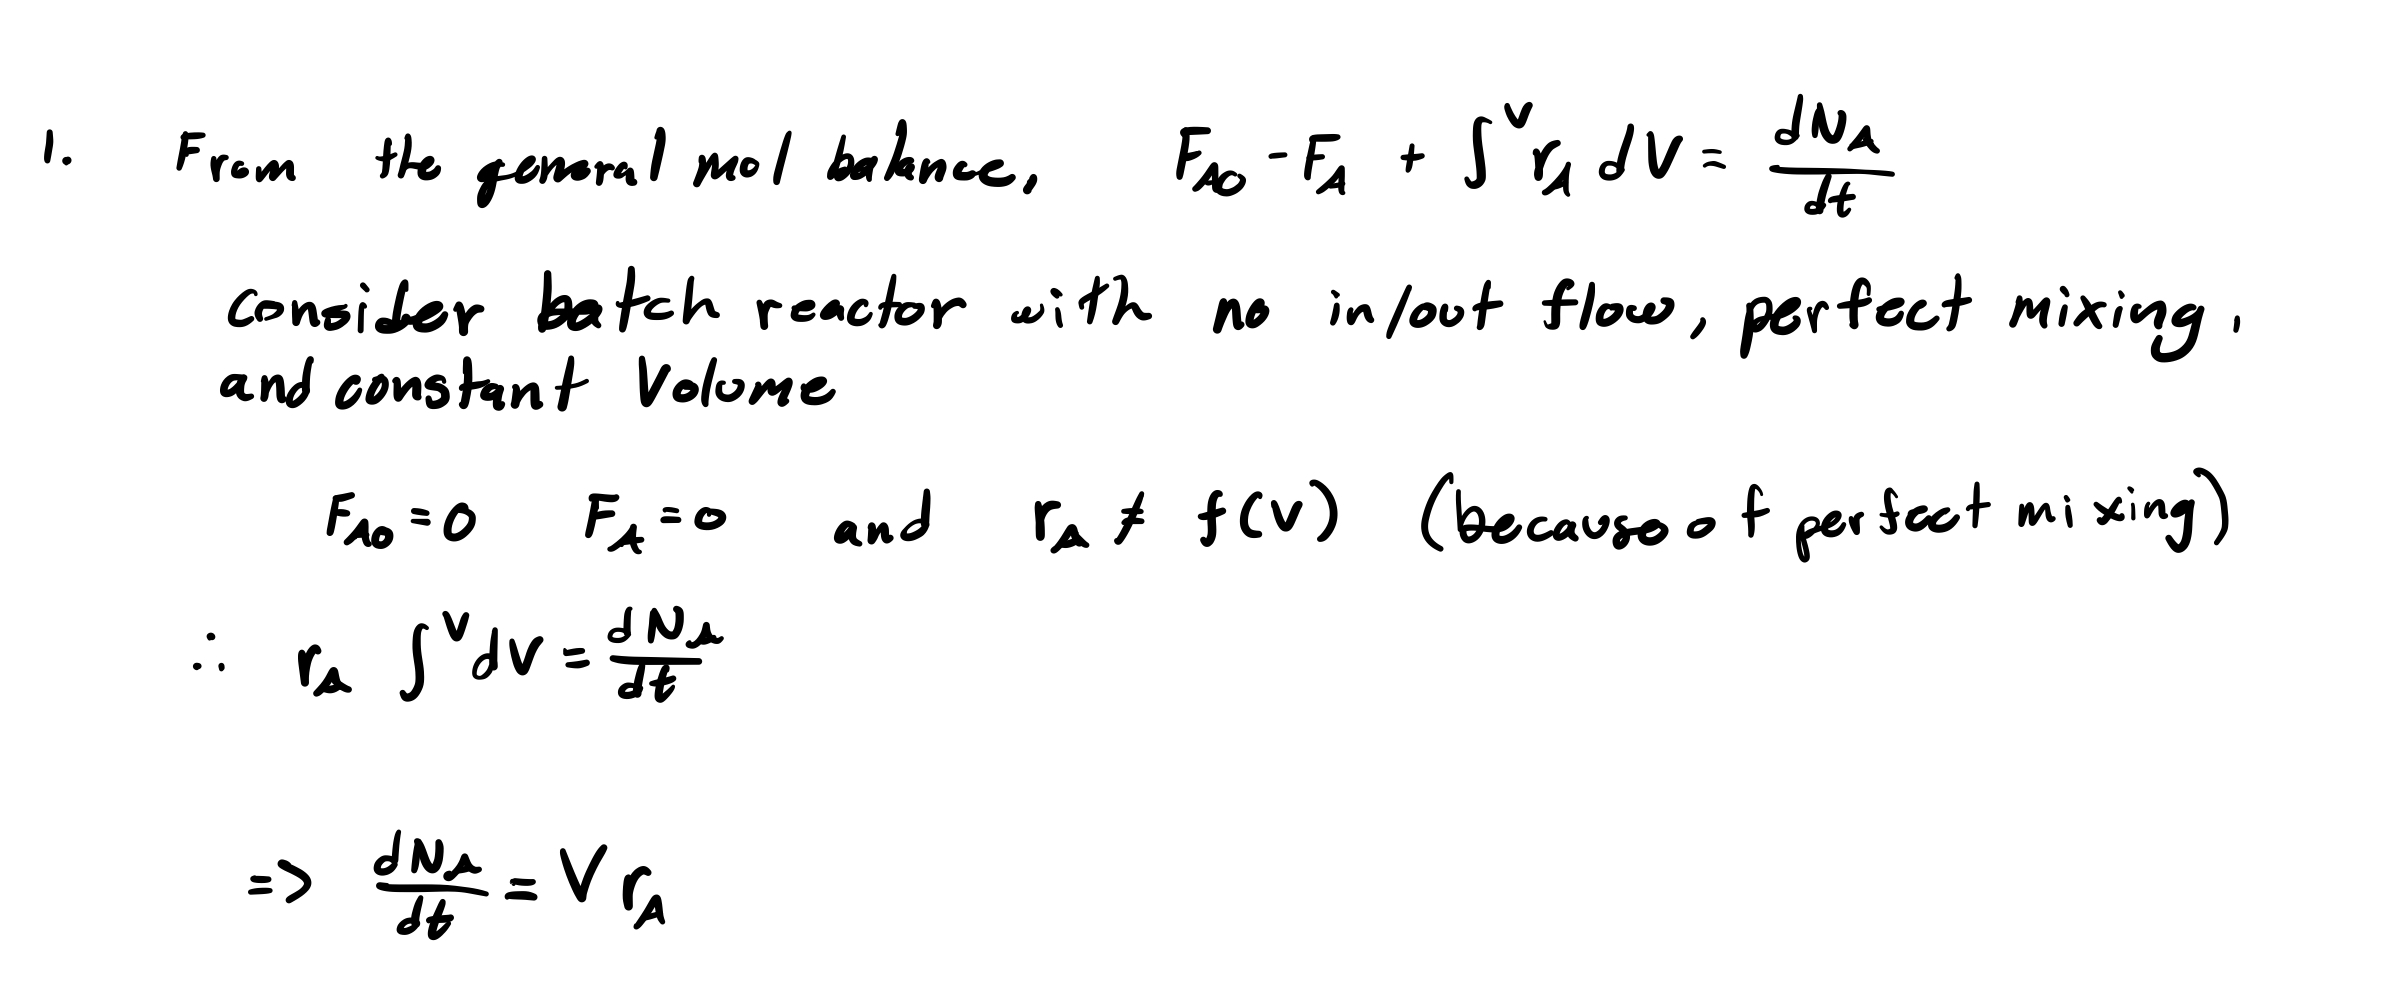

In [47]:
# FIXME:
# importing derivation screenshot
from IPython.display import Image
Image('./IMG_7CB1A92BE1BA-1.jpeg')

### 2) Finding rate constant and reaction order using two methods

#### Relating Concentration to Conductivity and Temperature Data

To find the concentrations of the reaction species at time $t$, we establish a relationship between concentration of our basis species, $C_A$, and total conductivity, $\Lambda_1$.

First, We approximate that only the ionic species, reactant A and product C, contribute to the measured total conductivity.

$$\Lambda_1 = \Lambda_{1A} + \Lambda_{1C}$$

Then we consider conductivity of a species as a function of partial concentration and system temperature.
Thus, $\Lambda_1i$ at a given time, $t$:

$$\Lambda_{1i}(t) = f(C_i(t), T_{sys}(t))$$
$$\Lambda_1 = \Lambda_{1A}(C_A, T) + \Lambda_{1C}(C_C, T)$$

Applying the system constraint that $C_C = f(C_A)$
$$C_A = C_{A0}(1-X_1)$$
$$C_C = C_{A0}X_1$$
We get
$$\Lambda_1(t) = f(C_A(t), (C_{A0} - C_A(t)), T(t)) => f(C_A(t), T(t))$$

Inverting and solving for $C_A(t)$:

$$C_A(t) = f(\Lambda_1(t), T(t))$$


In [3]:
# Saving tabulated values for partial conductivity
# Tabulated value data for each table: [(temperature, concentration, conductivity), ...]
data_NaOH_0_05 = [
    (20.5, 0.05, 11.14),
    (24.5, 0.05, 11.96),
    (25.5, 0.05, 12.16),
    (27.5, 0.05, 12.61),
    (29.7, 0.05, 13.07),
    (31.4, 0.05, 13.48),
    (33.4, 0.05, 13.93),
    (35.4, 0.05, 14.33)
]
data_NaOH_0_01 = [
    (22.5, 0.01, 1.98),
    (27.1, 0.01, 2.17),
    (28.1, 0.01, 2.20),
    (29.6, 0.01, 2.25),
    (31.3, 0.01, 2.33),
    (33.5, 0.01, 2.42),
    (35.4, 0.01, 2.45)
]
data_NaOH_0_001 = [
    (23.8, 0.001, 0.19),
    (26.9, 0.001, 0.20),
    (30.3, 0.001, 0.21),
    (31.4, 0.001, 0.21),
    (33.4, 0.001, 0.22),
    (35.4, 0.001, 0.23)
]

data_NaOAc_0_1 = [
    (24.9, 0.1, 7.04),
    (26.1, 0.1, 7.36),
    (27.6, 0.1, 7.78),
    (29.8, 0.1, 8.01),
    (31.4, 0.1, 8.33),
    (33.6, 0.1, 8.63),
    (33.5, 0.1, 9.09)
]
data_NaOAc_0_01 = [
    (21.7, 0.01, 0.68),
    (24.5, 0.01, 0.73),
    (25.8, 0.01, 0.75),
    (27.7, 0.01, 0.79),
    (29.7, 0.01, 0.81),
    (31.5, 0.01, 0.85),
    (33.5, 0.01, 0.89),
    (35.4, 0.01, 0.93)
]
data_NaOAc_0_001 = [
    (24.3, 0.001, 0.087),
    (30.5, 0.001, 0.10),
    (35.9, 0.001, 0.11)
]


In [4]:
# Reading in experimental batch data from excel file
run_data = pd.read_excel('Lab 1 Data Clean.xlsx', sheet_name=[0, 1, 2])

# print(run_data[1].columns)

run1_T = np.array(run_data[0]['Reactor \nTemp. \n \n[°C]']) + 273.15
run2_T = np.array(run_data[1]['Reactor \nTemp. \n \n[°C]']) + 273.15
run3_T = np.array(run_data[2]['Reactor \nTemp. \n \n[°C]']) + 273.15

run1_L = np.array(run_data[0]['Measured \nConductivity \n \n0 - 20 [mS]'])
run2_L = np.array(run_data[1]['Measured \nConductivity \n \n0 - 20 [mS]'])
run3_L = np.array(run_data[2]['Measured \nConductivity \n \n0 - 20 [mS]'])

# Removing first few data points to clean up data
run1_L = run1_L[1:]
run1_T = run1_T[1:]

run2_L = run2_L[4:]
run2_T = run2_T[4:]

run3_L = run3_L[6:]
run3_T = run3_T[6:]


In [5]:
# Formatting tabulated and experimental data
# Combine the tabulated data
data_NaOH = data_NaOH_0_05 + data_NaOH_0_01 + data_NaOH_0_001
data_NaOAc = data_NaOAc_0_1 + data_NaOAc_0_01 + data_NaOAc_0_001

# Convert the data to numpy arrays and convert to K, M, mS/cm
data_NaOH = np.array(data_NaOH)
data_NaOAc = np.array(data_NaOAc)
data_NaOH[:,0] += 273.15
data_NaOAc[:,0] += 273.15

exp_Ts = list(run1_T) + list(run2_T) + list(run3_T)
exp_Ts = np.array(exp_Ts)
exp_Ts = np.unique(exp_Ts)

In [6]:
# Interpolating conductivity of NaOH and NaOAc
NaOH_points = data_NaOH[:, [0, 1]]  # The first and second columns: temperature and concentration
NaOH_values = data_NaOH[:, 2]       # The third column: conductivity

NaOAc_points = data_NaOAc[:, [0, 1]]
NaOAc_values = data_NaOAc[:, 2]


# 2D interpolations
def NaOH_interp_C(temperature, concentration):
    return griddata(NaOH_points, NaOH_values, (temperature, concentration), method='cubic', fill_value=0.)

def NaOAc_interp_C(temperature, concentration):
    return griddata(NaOAc_points, NaOAc_values, (temperature, concentration), method='cubic', fill_value=0.)

In [7]:
# Combining partial conductivities and testing the interpolation functions

# Test the interpolation functions with temperature and conductivity
C_A0 = 0.4975*0.1/(2*0.4975 + 0.00488)
X_vec = np.linspace(0,.89,100)
C_a_vec = C_A0*(1-X_vec)
C_c_vec = C_A0*X_vec

C_a_vec, test_T1  = np.meshgrid(C_a_vec, exp_Ts)
C_c_vec, test_T2 = np.meshgrid(C_c_vec, exp_Ts)

lambda_1a = NaOH_interp_C(test_T1, C_a_vec)
lambda_1c =  NaOAc_interp_C(test_T1, C_c_vec)
lambda_1 = lambda_1a + lambda_1c

# plt.plot(X_vec, lambda_1[0])
# plt.xlabel(r'$X_A$')
# plt.ylabel(r'Estimated $\Lambda_1$')
# print(lambda_1.shape)
# print(lambda_1)

In [8]:
# Invert sum of partial conductivity interpolations to get concentration as a function of total conductivity
lambda_1_matrix = []
for i, conds in enumerate(lambda_1):
    Ts_i = [exp_Ts[i] for j in range(len(conds))]
    lambda_1_matrix.append(np.array([Ts_i, C_A0*(1-X_vec), conds]))

lambda_1_matrix = np.array(lambda_1_matrix)
new_arr = np.hstack(lambda_1_matrix).T

# print(new_arr.shape)
# print(new_arr)

tot_points = new_arr[:, [0, 2]]  # The first and second columns: temperature and conductivity
tot_values = new_arr[:, 1]       # The third column: concentrations

def tot_interp_C(temperature, conductivity):
    return griddata(tot_points, tot_values, (temperature, conductivity), method='cubic', fill_value=0.)

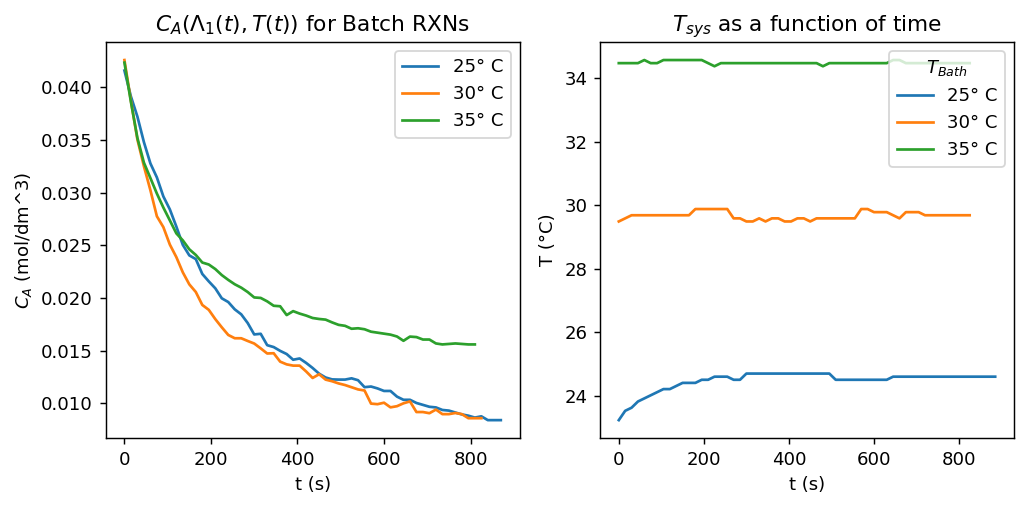

In [9]:
# Plot the interpolated total concentration as a function of time

C_a1 = tot_interp_C(run1_T, run1_L)
C_a2 = tot_interp_C(run2_T, run2_L)
C_a3 = tot_interp_C(run3_T, run3_L)

time_vec1 = np.arange(0, (len(run1_T))*15, 15)
time_vec2 = np.arange(0, (len(run2_T))*15, 15)
time_vec3 = np.arange(0, (len(run3_T))*15, 15)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(time_vec1[:-1], C_a1[1:])
ax[0].plot(time_vec2, C_a2)
ax[0].plot(time_vec3[:-1], C_a3[1:])

ax[0].set_xlabel('t (s)')
ax[0].set_ylabel(r'$C_A$ (mol/dm^3)')
ax[0].set_title(r'$C_A(\Lambda_1(t), T(t))$ for Batch RXNs')
ax[0].legend(['25° C','30° C', '35° C'])

ax[1].plot(time_vec1, run1_T - 273.15)
ax[1].plot(time_vec2, run2_T - 273.15)
ax[1].plot(time_vec3, run3_T - 273.15)
ax[1].set_xlabel('t (s)')
ax[1].set_ylabel(r'T (°C)')
ax[1].set_title(r'$T_{sys}$ as a function of time')
ax[1].legend(['25° C','30° C', '35° C'], loc='upper right', title=r'$T_{Bath}$')

plt.tight_layout()

# plt.plot(time_vec2, testResult2)
# plt.xlabel('t (s)')
# plt.ylabel(r'$C_A$ (mol/$dm^3$)')
# plt.title(r'$C_A(\Lambda_1(t), T(t))$ for 30° Batch RXN')

In [10]:
# plt.scatter(time_vec3, C_a3)
# plt.xlabel('t (s)')
# plt.ylabel(r'$C_A$ (mol/$dm^3$)')
# plt.title(r'$C_A(\Lambda_1(t), T(t))$ for 35° Batch RXN')

#### Analyzing C_A vs t data to find rate constants

For each Temperature, the C_A(t) should follow the generic rate law:
$$-r_A = -\frac{d}{dt}(C_A) = k C_A^\alpha C_B^\beta$$

Where 
$$C_A = C_{A0}(1 - X)$$

$$C_B = C_{B0} - C_{A0}X$$

$$C_B = C_{B0} + C_{A} - C_{A0}$$

Plugging into the generic rate law
$$ -\frac{d}{dt}(C_A) = k C_A^\alpha (C_A + C_{B0}-C_{A0})^\beta$$

Then to find the rate constant and rate parameters, we use the following two numerical methods:


A) we fit each reaction rate to the generic rate law using scipy.optimize's non-linear least squares `curve_fit` method


B) we approximate the difference in initial concentrations of the reactants as negligible to perform a least squares linear regression
$$C_{B0} - C_{A0} \approx 0$$
$$\Rightarrow -\frac{d}{dt}(C_A)= k C_A^{\alpha+\beta}$$

$$\log(-\frac{d}{dt}(C_A)) = log(k) + (\alpha + \beta)\log(C_A))




##### A) Fitting parameters via `curve_fit`

In [11]:
# Performing curve_fit on gradient of concentration vs concentration to find the rate parameters

grad_C_a1 = np.gradient(C_a1, time_vec1)
grad_C_a2 = np.gradient(C_a2, time_vec2)
grad_C_a3 = np.gradient(C_a3, time_vec3)

# Molarity of EtOAc from density at 25° C
EtOAc_M = 0.902/88.106*1e3 # (g/mL) / (g/mol) * (mL/L) 

# Initial concentrations of A and B
C_A0 = 0.4975*0.1/(2*0.4975 + 0.00488)
C_B0 = 0.00488*EtOAc_M/(2*0.4975 + 0.00488)

def generic_ratelaw(C_A, k, alpha, beta, C_A0=C_A0, C_B0=C_B0):
    return k * C_A**alpha * (C_A + C_B0 - C_A0)**beta

# Using scipys curve_fit function to fit the data to the generic rate law with the initial guesses of k = 1, alpha = 1, beta = 1
params_T1_nonlin, pcov_T1 = curve_fit(generic_ratelaw, C_a1, -1*grad_C_a1, p0=[0.2, 1, 1], bounds=((0, -0, -0), (np.inf, 3, 3)))
params_T2_nonlin, pcov_T2 = curve_fit(generic_ratelaw, C_a2, -1*grad_C_a2, p0=[0.2, 1, 1], bounds=((0, -0, -0), (np.inf, 3, 3)))
params_T3_nonlin, pcov_T3 = curve_fit(generic_ratelaw, C_a3[:-8], -1*grad_C_a3[:-8], p0=[60, 1, 1], bounds=((0, -0, -0), (np.inf, 4, 4)), method='trf')

In [12]:
# Confidence intervals for the parameters via the fitting covariance matrix

def conf_interval(x, popt, pcov, alpha=0.05):
    n = len(x)
    p = len(popt)
    dof = max(0, n - p) # degrees of freedom
    tval = stats.t.ppf(1.0-alpha/2., dof) # t value
    sigma = np.sqrt(np.diag(pcov)) # sterr from covariance matrix
    confs = []
    for i, p in enumerate(popt):
        confs.append(sigma[i]*tval)
    return confs

conf_T1_nonlin = conf_interval(C_a1, params_T1_nonlin, pcov_T1)
conf_T2_nonlin = conf_interval(C_a2, params_T2_nonlin, pcov_T2)
conf_T3_nonlin = conf_interval(C_a3[:-8], params_T3_nonlin, pcov_T3)

# print(conf_T1_nonlin)

print('Nonlinear Regression Confidence intervals for 95% confidence:')
print(r'25° C params: {k: %.4f ± %.4f, alpha: %.4f ± %.4f, beta: %.4f ± %.4f' % (params_T1_nonlin[0], conf_T1_nonlin[0], params_T1_nonlin[1], conf_T1_nonlin[1], params_T1_nonlin[2], conf_T1_nonlin[2]))
print(r'30° C params: {k: %.4f ± %.4f, alpha: %.4f ± %.4f, beta: %.4f ± %.4f' % (params_T2_nonlin[0], conf_T2_nonlin[0], params_T2_nonlin[1], conf_T2_nonlin[1], params_T2_nonlin[2], conf_T2_nonlin[2]))
print(r'35° C params: {k: %.4f ± %.4f, alpha: %.4f ± %.4f, beta: %.4f ± %.4f' % (params_T3_nonlin[0], conf_T3_nonlin[0], params_T3_nonlin[1], conf_T3_nonlin[1], params_T3_nonlin[2], conf_T3_nonlin[2]))

Nonlinear Regression Confidence intervals for 95% confidence:
25° C params: {k: 0.0786 ± 0.1434, alpha: 0.9559 ± 75.8091, beta: 0.9613 ± 76.4703
30° C params: {k: 0.2149 ± 0.4469, alpha: 1.0544 ± 85.2833, beta: 1.0527 ± 86.0350
35° C params: {k: 4.8146 ± 31.5664, alpha: 1.5577 ± 389.0989, beta: 1.5913 ± 391.7442


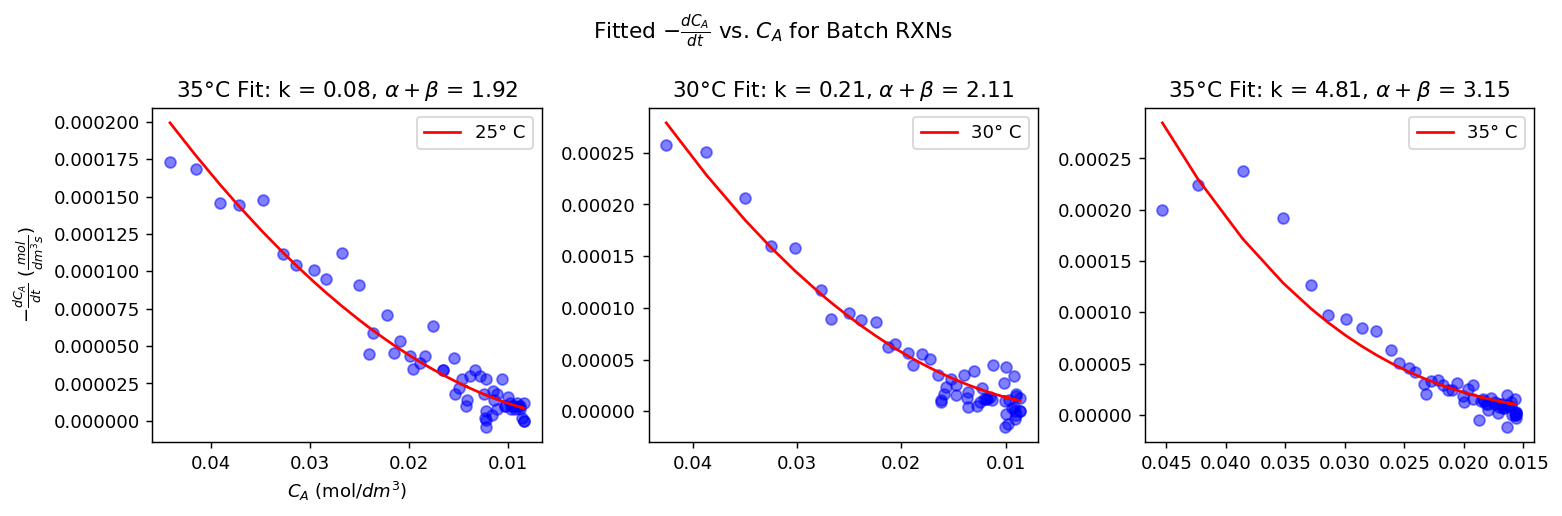

In [38]:
# Plotting the curve_fit of the generic rate law vs C_A
fig, ax = plt.subplots(1,3, figsize=(12,4))

ax[0].plot(C_a1, generic_ratelaw(C_a1, *params_T1_nonlin), color='r')
ax[0].scatter(C_a1, -1*grad_C_a1, alpha=0.5, color='b')
ax[0].invert_xaxis()
ax[0].set_xlabel(r'$C_A$ (mol/$dm^3$)')
ax[0].set_ylabel(r'$-\frac{dC_A}{dt}$ ($\frac{mol}{dm^3 s}$)')
ax[0].legend(['25° C'])
ax[0].set_title(r'35°C Fit: k = %.2f, $\alpha + \beta$ = %.2f' % (params_T1_nonlin[0], params_T1_nonlin[1] + params_T1_nonlin[2]))


ax[1].plot(C_a2, generic_ratelaw(C_a2, *params_T2_nonlin), color='r')
ax[1].scatter(C_a2, -1*grad_C_a2, alpha=0.5, color='b')
ax[1].invert_xaxis()
# ax[1].set_xlabel(r'$C_A$ (mol/$dm^3$)')
# ax[1].set_ylabel(r'$-\frac{dC_A}{dt}$ (mol/$dm^3$)')
ax[1].legend(['30° C'])
ax[1].set_title(r'30°C Fit: k = %.2f, $\alpha + \beta$ = %.2f' % (params_T2_nonlin[0], params_T2_nonlin[1] + params_T2_nonlin[2]))

ax[2].plot(C_a3, generic_ratelaw(C_a3, *params_T3_nonlin), color='r')
ax[2].scatter(C_a3, -1*grad_C_a3, alpha=0.5, color='b')
ax[2].invert_xaxis()
# ax[2].set_xlabel(r'$C_A$ (mol/$dm^3$)')
# ax[2].set_ylabel(r'$-\frac{dC_A}{dt}$ (mol/$dm^3$)')
ax[2].legend(['35° C'])
ax[2].set_title(r'35°C Fit: k = %.2f, $\alpha + \beta$ = %.2f' % (params_T3_nonlin[0], params_T3_nonlin[1] + params_T3_nonlin[2]))

plt.suptitle(r'Fitted $-\frac{dC_A}{dt}$ vs. $C_A$ for Batch RXNs')
plt.tight_layout()

In [14]:
# Plotting the curve_fit of the generic rate law vs time
# fig, ax = plt.subplots(1,3, figsize=(12,4))

# ax[0].scatter(time_vec1, grad_C_a1 * -1, alpha=0.5)
# ax[0].plot(time_vec1, generic_ratelaw(C_a1, *popt_T1))
# ax[0].set_xlabel('time (s)')
# ax[0].set_ylabel(r'$-\frac{dC_A}{dt}$ (mol/$dm^3$)')
# ax[0].set_title(r'$-\frac{dC_A}{dt}$ vs. $t$ for 25° Batch RXN')

# ax[1].scatter(time_vec2, grad_C_a2 * -1, alpha=0.5)
# ax[1].plot(time_vec2, generic_ratelaw(C_a2, *popt_T2))
# ax[1].set_xlabel('time (s)')
# ax[1].set_ylabel(r'$-\frac{dC_A}{dt}$ (mol/$dm^3$)')
# ax[1].set_title(r'$-\frac{dC_A}{dt}$ vs. $t$ for 30° Batch RXN')

# ax[2].scatter(time_vec3, grad_C_a3 * -1, alpha=0.5)
# ax[2].plot(time_vec3, generic_ratelaw(C_a3, *popt_T3))
# ax[2].set_xlabel('time (s)')
# ax[2].set_ylabel(r'$-\frac{dC_A}{dt}$ (mol/$dm^3$)')
# ax[2].set_title(r'$-\frac{dC_A}{dt}$ vs. $t$ for 35° Batch RXN')
# plt.tight_layout()


##### B) Fitting Parameters using the differential method via Linear Regression of $\log(-\frac{dC_A}{dt})$ vs $C_A$

In [15]:
# Performing a linear regression on the negative log of the gradient of C_A vs C_A

# smoothing concentration data to remove noise for log of derivatives via Savitzky-Golay filter
smooth_C_a1 = savgol_filter(C_a1, 21, 3)
smooth_C_a2 = savgol_filter(C_a2, 21, 3)
smooth_C_a3 = savgol_filter(C_a3, 21, 3)

neglog_grad_C_a1 = np.log(np.gradient(smooth_C_a1, 15) * -1)
neglog_grad_C_a2 = np.log(np.gradient(smooth_C_a2, 15) * -1)
neglog_grad_C_a3 = np.log(np.gradient(smooth_C_a3, 15) * -1)

# performing least squares linear regression on the negative log of the gradient of smoothened C_A vs C_A
params_T1_lin, cov1_lin = np.polyfit(np.log(smooth_C_a1), neglog_grad_C_a1, 1, cov=True)
params_T2_lin, cov2_lin = np.polyfit(np.log(smooth_C_a2), neglog_grad_C_a2, 1, cov=True)
params_T3_lin, cov3_lin = np.polyfit(np.log(smooth_C_a3), neglog_grad_C_a3, 1, cov=True)

poly1 = np.poly1d(params_T1_lin)
poly2 = np.poly1d(params_T2_lin)
poly3 = np.poly1d(params_T3_lin)

# Removing the last 15 points from the data to improve fit
z3_trunc, cov3_trunc = np.polyfit(np.log(smooth_C_a3)[:-15], neglog_grad_C_a3[:-15], 1, cov=True)
poly3_trunc = np.poly1d(z3_trunc)

In [16]:
# Linear Regression error analysis

# 95% confidence interval for linear regression
conf_T1_lin = conf_interval(np.log(smooth_C_a1), params_T1_lin, cov1_lin, alpha = 0.05)
conf_T2_lin = conf_interval(np.log(smooth_C_a2), params_T2_lin, cov2_lin, alpha = 0.05)
conf_T3_lin = conf_interval(np.log(smooth_C_a3), params_T3_lin, cov3_lin, alpha = 0.05)
conf_T3_lin_trunc = conf_interval(np.log(smooth_C_a3)[:-15], z3_trunc, cov3_trunc, alpha = 0.05)

print('Linear Regression Confidence intervals for 95% confidence:')
print('25° C: {k: %.4f ± %.4f, ab: %.4f ± %.4f}' % (np.exp(params_T1_lin[1]), np.exp(conf_T1_lin[1]), params_T1_lin[0], conf_T1_lin[0]))
print('30° C: {k: %.4f ± %.4f, ab: %.4f ± %.4f}' % (np.exp(params_T2_lin[1]), np.exp(conf_T2_lin[1]), params_T2_lin[0], conf_T2_lin[0]))
print('35° C: {k: %.4f ± %.4f, ab: %.4f ± %.4f}' % (np.exp(params_T3_lin[1]), np.exp(conf_T3_lin[1]), params_T3_lin[0], conf_T3_lin[0]))
print('35° C (truncated): {k: %.4f ± %.4f, ab: %.4f ± %.4f}' % (np.exp(z3_trunc[1]), np.exp(conf_T3_lin_trunc[1]), z3_trunc[0], conf_T3_lin_trunc[0]))


Linear Regression Confidence intervals for 95% confidence:
25° C: {k: 0.1507 ± 1.4656, ab: 2.0807 ± 0.0908}
30° C: {k: 0.6390 ± 2.0420, ab: 2.4149 ± 0.1674}
35° C: {k: 508.8582 ± 4.9941, ab: 4.4308 ± 0.4122}
35° C (truncated): {k: 60.5137 ± 2.1977, ab: 3.8412 ± 0.2065}


In [17]:
# Taking Rough logarithms and Smoothing analysis (not-in-domain errors thrown)

neglog_grad_C_a1_rough = np.log(np.gradient(C_a1, 15) * -1)
neglog_grad_C_a2_rough = np.log(np.gradient(C_a2, 15) * -1)
neglog_grad_C_a3_rough = np.log(np.gradient(C_a3, 15) * -1)

# print(neglog_grad_C_a1.shape)
# print(neglog_grad_C_a1_rough.shape)
# plt.scatter(time_vec1, neglog_grad_C_a1, color='blue')
# plt.plot(time_vec2, neglog_grad_C_a2, color='orange')
# plt.plot(time_vec3, neglog_grad_C_a3, color='green')
# plt.scatter(time_vec1, np.log(np.gradient(C_a1, 15) * -1), color='blue')
# plt.plot(time_vec2, np.log(np.gradient(C_a2, 15) * -1), color='orange')
# plt.plot(time_vec3, np.log(np.gradient(C_a3, 15) * -1), color='green')

/var/folders/l7/3t0xgd4j28d8kmd67v75drlm0000gn/T/ipykernel_50892/4119997299.py:3: RuntimeWarning: divide by zero encountered in log
  neglog_grad_C_a1_rough = np.log(np.gradient(C_a1, 15) * -1)
/var/folders/l7/3t0xgd4j28d8kmd67v75drlm0000gn/T/ipykernel_50892/4119997299.py:3: RuntimeWarning: invalid value encountered in log
  neglog_grad_C_a1_rough = np.log(np.gradient(C_a1, 15) * -1)
/var/folders/l7/3t0xgd4j28d8kmd67v75drlm0000gn/T/ipykernel_50892/4119997299.py:4: RuntimeWarning: divide by zero encountered in log
  neglog_grad_C_a2_rough = np.log(np.gradient(C_a2, 15) * -1)
/var/folders/l7/3t0xgd4j28d8kmd67v75drlm0000gn/T/ipykernel_50892/4119997299.py:4: RuntimeWarning: invalid value encountered in log
  neglog_grad_C_a2_rough = np.log(np.gradient(C_a2, 15) * -1)
/var/folders/l7/3t0xgd4j28d8kmd67v75drlm0000gn/T/ipykernel_50892/4119997299.py:5: RuntimeWarning: divide by zero encountered in log
  neglog_grad_C_a3_rough = np.log(np.gradient(C_a3, 15) * -1)
/var/folders/l7/3t0xgd4j28d8kmd6

In [18]:
# Alternative method of preparing data for linear regression via removing nan values (not used)

# remove_nan =  (lambda v: v==v) # removes nan values from the array
# C_a3_copy = C_a3[remove_nan(neglog_grad_C_a3_rough)]
# neglog_grad_C_a3_rough = neglog_grad_C_a3_rough[remove_nan(neglog_grad_C_a3_rough)]

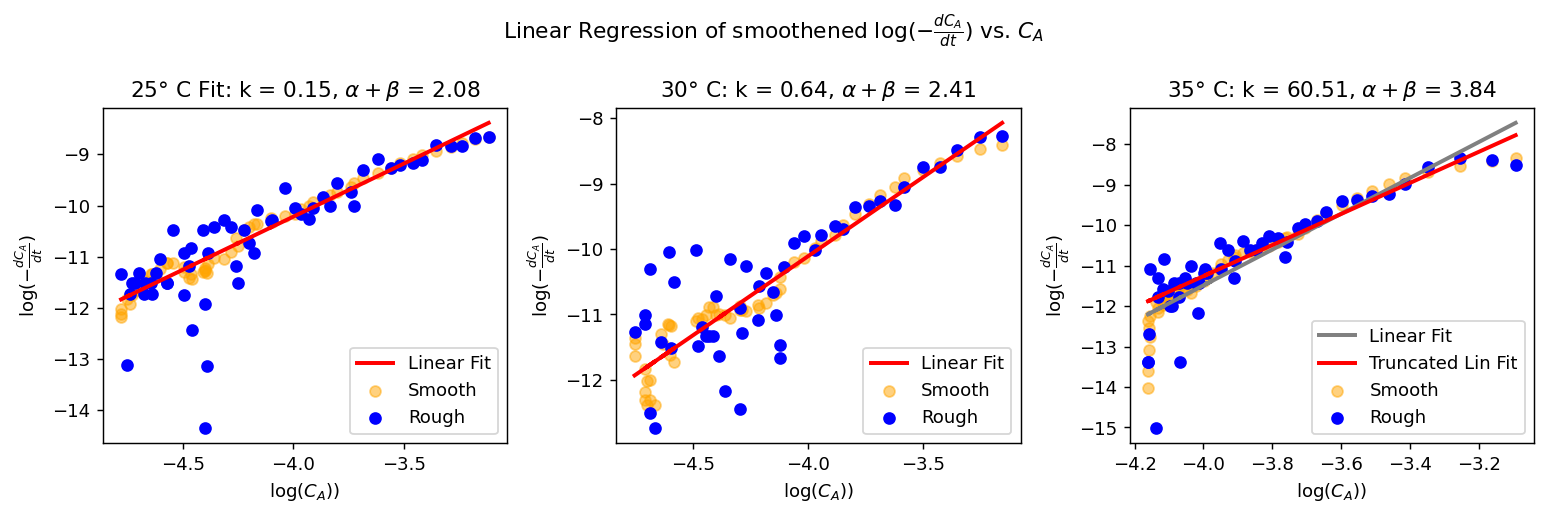

In [19]:
# Plotting the linear Regressions of the negative log of the gradient of C_A vs log C_A
fig, ax = plt.subplots(1,3, figsize=(12,4))

ax[0].plot(np.log(C_a1), poly1(np.log(C_a1)), color='red', linewidth=2.2)
ax[0].scatter(np.log(C_a1), neglog_grad_C_a1, color='orange', alpha=0.5)
ax[0].scatter(np.log(C_a1), neglog_grad_C_a1_rough, color='blue', alpha=1)
ax[0].set_xlabel(r'$\log(C_A)$)')
ax[0].set_ylabel(r'$\log(-\frac{dC_A}{dt})$')
ax[0].legend(['Linear Fit', 'Smooth', 'Rough'], loc='lower right')
ax[0].set_title(r'25° C Fit: k = %.2f, $\alpha + \beta$ = %.2f' % (np.exp(params_T1_lin[1]), params_T1_lin[0]))

ax[1].plot(np.log(C_a2), poly2(np.log(C_a2)), color='red', linewidth=2.2)
ax[1].scatter(np.log(C_a2), neglog_grad_C_a2, color='orange', alpha=0.5)
ax[1].scatter(np.log(C_a2), neglog_grad_C_a2_rough, color='blue', alpha=1)
ax[1].set_xlabel(r'$\log(C_A)$)')
ax[1].set_ylabel(r'$\log(-\frac{dC_A}{dt})$')
ax[1].legend(['Linear Fit', 'Smooth', 'Rough'], loc='lower right')
ax[1].set_title(r'30° C: k = %.2f, $\alpha + \beta$ = %.2f' % (np.exp(params_T2_lin[1]), params_T2_lin[0]))

ax[2].plot(np.log(C_a3), poly3(np.log(C_a3)), color='grey', linewidth=2.2)
ax[2].plot(np.log(C_a3), poly3_trunc(np.log(C_a3)), color='red', linewidth=2.2)
ax[2].scatter(np.log(C_a3), neglog_grad_C_a3, color='orange', alpha=0.5)
ax[2].scatter(np.log(C_a3), neglog_grad_C_a3_rough, color='blue', alpha=1)
ax[2].legend(['Linear Fit', 'Truncated Lin Fit', 'Smooth', 'Rough'], loc='lower right')
ax[2].set_xlabel(r'$\log(C_A)$)')
ax[2].set_ylabel(r'$\log(-\frac{dC_A}{dt})$')
ax[2].set_title(r'35° C: k = %.2f, $\alpha + \beta$ = %.2f' % (np.exp(z3_trunc[1]), z3_trunc[0]))


plt.suptitle(r'Linear Regression of smoothened $\log(-\frac{dC_A}{dt})$ vs. $C_A$')
plt.tight_layout()


##### Comparing Fitting Results

In [20]:
# Integrating the fit parameters to show comparison with the original data

def generic_ratelaw_i(t, C_A, k: float, alpha: float, beta: float, C_A0=C_A0, C_B0=C_B0):
    return -1* k * C_A**alpha * (C_A + C_B0 - C_A0)**beta

def generic_ratelaw_j(t, C_A, k: float, alpha_beta: float):
    return -1* k * C_A**(alpha_beta)


# synth_args = [*popt_T3_smooth, 0.05, 0.05]

integ1_i = solve_ivp(generic_ratelaw_i, [time_vec1[0], time_vec1[-1]], [C_a1[0]], t_eval=time_vec1, args=params_T1_nonlin)
integ2_i = solve_ivp(generic_ratelaw_i, [time_vec2[0], time_vec2[-1]], [C_a2[0]], t_eval=time_vec2, args=params_T2_nonlin)
integ3_i = solve_ivp(generic_ratelaw_i, [time_vec3[0], time_vec3[-1]], [C_a3[0]], t_eval=time_vec3, args=params_T3_nonlin)
# integ3_i_smooth = solve_ivp(generic_ratelaw_i, [time_vec3[0], time_vec3[-1]], [C_a3[0]], t_eval=time_vec3, args=popt_T3_smooth)

integ1_j = solve_ivp(generic_ratelaw_j, [time_vec1[0], time_vec1[-1]], [C_a1[0]], t_eval=time_vec1, args=(np.exp(params_T1_lin[1]), params_T1_lin[0]))
integ2_j = solve_ivp(generic_ratelaw_j, [time_vec2[0], time_vec2[-1]], [C_a2[0]], t_eval=time_vec2, args=(np.exp(params_T2_lin[1]), params_T2_lin[0]))
integ3_j = solve_ivp(generic_ratelaw_j, [time_vec3[0], time_vec3[-1]], [C_a3[0]], t_eval=time_vec3, args=(np.exp(z3_trunc[1]), z3_trunc[0]))


Text(0.5, 1.0, 'Integrated Non-linear and Linear Fits of $\\frac{dC_A}{dt}$')

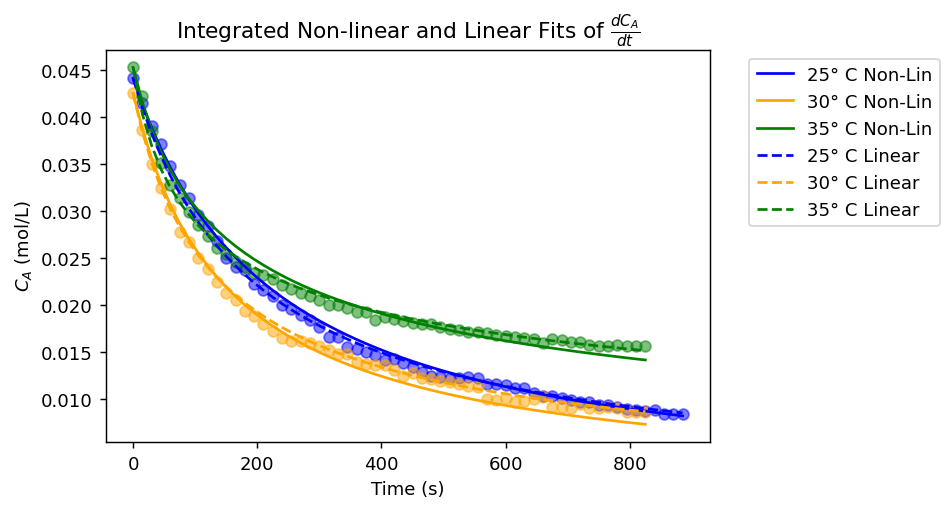

In [21]:
# Plotting the integrated data to compare fits with the original data
plt.plot(integ1_i.t, integ1_i.y[0], color='blue')
plt.plot(integ2_i.t, integ2_i.y[0], color='orange')
plt.plot(integ3_i.t, integ3_i.y[0], color='green')

plt.plot(integ1_j.t, integ1_j.y[0], color='blue', linestyle='--')
plt.plot(integ2_j.t, integ2_j.y[0], color='orange', linestyle='--')
plt.plot(integ3_j.t, integ3_j.y[0], color='green', linestyle='--')

plt.scatter(time_vec1, C_a1, color='blue', alpha=0.5)
plt.scatter(time_vec2, C_a2, color='orange', alpha=0.5)
plt.scatter(time_vec3, C_a3, color='green', alpha=0.5)

plt.legend(['25° C Non-Lin', '30° C Non-Lin', '35° C Non-Lin', '25° C Linear', '30° C Linear', '35° C Linear'], 
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Time (s)')
plt.ylabel(r'$C_A$ (mol/L)')
plt.title(r'Integrated Non-linear and Linear Fits of $\frac{dC_A}{dt}$')

# could quantify the difference between linear and non-linear fits by comparing the sum of the squared residuals - will show that the linear fit is better

The Linear Regression Fits predict the $C_A(t)$ better than the non-linear Fits for all temperatures at most time points (esp as $t \rightarrow \infty$)

The linear fit could be better because of the Savitzky-Golay data filtering applied to the concentration data (necessary to take the logarithm of the derivative without out-of-bounds errors). However, likely much more of a differentiator is the unstability of the Trust Region Reflective algorithm for constrained non-linear regression (using the constraint that the order of each reactant must be positive). Small changes in the initial value guesses result in large shifts in the constant fits. These errors are particularly visible for the 35° non-linear fit where the end behavior of the concentration and reaction rate does not match the end behavior of the derivative. 

Additionally, the assumption that k does not vary with T for the fits within experiments where the T varies is a source of error. 

Below is an effort to further constrain the curve-fits to more accurately reflect the reaction orders found in the linear regression fits. The goal is that by constraining the reaction orders more heavily, the calculated k values might be more reflective of the literature values modeled for second order reaction rates.

In [22]:
# Using curve_fit while constraining reaction orders of A and B to 1, to find the rate constant k

popt_T1_constr, pcov_T1_constr = curve_fit(generic_ratelaw, C_a1, -1*grad_C_a1, p0=[0.15, 1, 1], bounds=((0, 1, 1), (np.inf, 1.04, 1.04)))
popt_T2_constr, pcov_T2_constr = curve_fit(generic_ratelaw, C_a2, -1*grad_C_a2, p0=[0.5, 1, 1], bounds=((0, 1, 1), (np.inf, 1.205, 1.205)))
popt_T3_constr, pcov_T3_constr = curve_fit(generic_ratelaw, C_a3, -1*grad_C_a3, p0=[0.565, 1, 1], bounds=((0, 1, 1), (np.inf, 1.92, 1.92)))

print(popt_T1_constr, np.sqrt(np.diag(pcov_T1_constr)))
print(popt_T2_constr, np.sqrt(np.diag(pcov_T2_constr)))
print(popt_T3_constr, np.sqrt(np.diag(pcov_T3_constr)))

# print('RXN Fit parameters with constraints: [k, alpha, beta]')
# print('25° C params: ', popt_T1_constr)
# print('30° C params: ', popt_T2_constr)
# print('35° C params: ', popt_T3_constr)

[0.1104822  1.00786643 1.00787997] [ 0.1097486  42.37884275 42.74091626]
[0.28268191 1.09243699 1.09238018] [ 0.2955199  43.71478023 44.09431643]
[0.49728915 1.23474023 1.23400266] [  1.25884437 136.0738671  137.06978251]


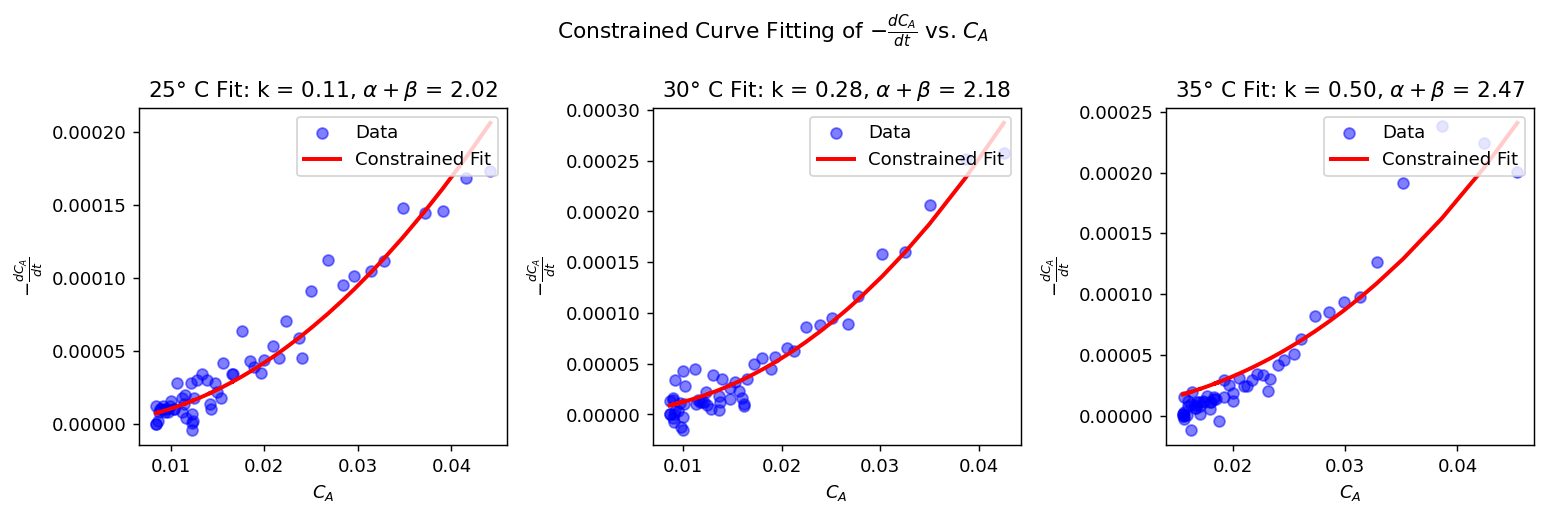

In [43]:
# Plotting the constrained curve fits; they are not as good as the unconstrained fits

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].scatter(C_a1, -1*grad_C_a1, color='blue', alpha=0.5)
ax[0].plot(C_a1, generic_ratelaw(C_a1, *popt_T1_constr), color='red', linewidth=2.2)
ax[0].set_xlabel(r'$C_A$')
ax[0].set_ylabel(r'$-\frac{dC_A}{dt}$')
ax[0].legend(['Data', 'Constrained Fit'], loc='upper right')
ax[0].set_title(r'25° C Fit: k = %.2f, $\alpha + \beta$ = %.2f' % (popt_T1_constr[0], popt_T1_constr[1] + popt_T1_constr[2]))

ax[1].scatter(C_a2, -1*grad_C_a2, color='blue', alpha=0.5)
ax[1].plot(C_a2, generic_ratelaw(C_a2, *popt_T2_constr), color='red', linewidth=2.2)
ax[1].set_xlabel(r'$C_A$')
ax[1].set_ylabel(r'$-\frac{dC_A}{dt}$')
ax[1].legend(['Data', 'Constrained Fit'], loc='upper right')
ax[1].set_title(r'30° C Fit: k = %.2f, $\alpha + \beta$ = %.2f' % (popt_T2_constr[0], popt_T2_constr[1] + popt_T2_constr[2]))

ax[2].scatter(C_a3, -1*grad_C_a3, color='blue', alpha=0.5)
ax[2].plot(C_a3, generic_ratelaw(C_a3, *popt_T3_constr), color='red', linewidth=2.2)
ax[2].set_xlabel(r'$C_A$')
ax[2].set_ylabel(r'$-\frac{dC_A}{dt}$')
ax[2].legend(['Data', 'Constrained Fit'], loc='upper right')
ax[2].set_title(r'35° C Fit: k = %.2f, $\alpha + \beta$ = %.2f' % (popt_T3_constr[0], popt_T3_constr[1] + popt_T3_constr[2]))

plt.suptitle(r'Constrained Curve Fitting of $-\frac{dC_A}{dt}$ vs. $C_A$')
plt.tight_layout()

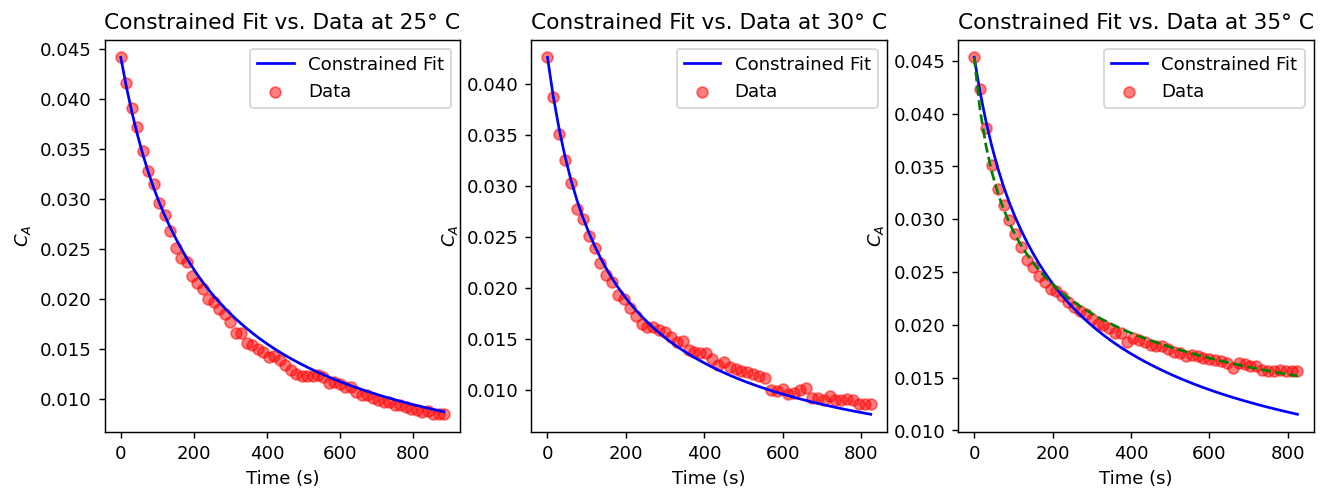

In [24]:
# Integrating the constrained fits to compare with the original data

integ1_i_CONSTR = solve_ivp(generic_ratelaw_i, [time_vec1[0], time_vec1[-1]], [C_a1[0]], t_eval=time_vec1, args=popt_T1_constr)
integ2_i_CONSTR = solve_ivp(generic_ratelaw_i, [time_vec2[0], time_vec2[-1]], [C_a2[0]], t_eval=time_vec2, args=popt_T2_constr)
integ3_i_CONSTR = solve_ivp(generic_ratelaw_i, [time_vec3[0], time_vec3[-1]], [C_a3[0]], t_eval=time_vec3, args=popt_T3_constr)
# integ3_i_Marks = solve_ivp(generic_ratelaw_i, [time_vec3[0], time_vec3[-1]], [C_a3[0]], t_eval=time_vec3, args=[0.3634, 1, 1])

# Plotting the integrated data to compare constrained fits with the original data

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].plot(integ1_i_CONSTR.t, integ1_i_CONSTR.y[0], color='blue')
ax[0].scatter(time_vec1, C_a1, color='red', alpha=0.5)

ax[1].plot(integ2_i_CONSTR.t, integ2_i_CONSTR.y[0], color='blue')
ax[1].scatter(time_vec2, C_a2, color='red', alpha=0.5)

ax[2].plot(integ3_i_CONSTR.t, integ3_i_CONSTR.y[0], color='blue')
ax[2].scatter(time_vec3, C_a3, color='red', alpha=0.5)
plt.plot(integ3_j.t, integ3_j.y[0], color='green', linestyle='--')



for i in range(3):
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylabel(r'$C_A$')
    ax[i].legend(['Constrained Fit', 'Data'], loc='upper right')
    ax[i].set_title(r'Constrained Fit vs. Data at %d° C' % (25+i*5))

In [25]:
# Curve Fitting with smoothed concentration data
# plt.scatter(C_a3, np.gradient(C_a3, 15) * -1, color='red', alpha=0.5)
# for i in range(5,25,2):
#     smooth_C_a3_test = savgol_filter(C_a3[5:], i, 3)
#     ngrad_C_a3_smooth = np.gradient(smooth_C_a3_test, 15) * -1

#     # plt.plot(smooth_C_a3_test, ngrad_C_a3_smooth, color='blue', alpha=0.5)

#     params_T3_nonlin_smooth, pcov_T3_smooth = curve_fit(generic_ratelaw, smooth_C_a3_test, ngrad_C_a3_smooth, p0=[1, 2, 1], bounds=((0, -0, -0), (np.inf, np.inf, np.inf)))

#     plt.plot(C_a3, generic_ratelaw(C_a3, *params_T3_nonlin_smooth), color='navy', linewidth=2.2)
#     print('35° C params (smoothed): ', i, params_T3_nonlin_smooth, np.sqrt(np.diag(pcov_T3_smooth)))

### 2) Finding the Arrhenius Equation Parameters

The temperarture dependence of the reaction rate constant, k, is modeled by the Arrhenius equation.
$$ k(T) = A\exp(-\frac{E_A}{RT}) $$
Plotting our experimental values for $k(\bar T_{sys})$ with the literature values found in Das et. al, 2011 (https://doi.org/10.1002/kin.20597):

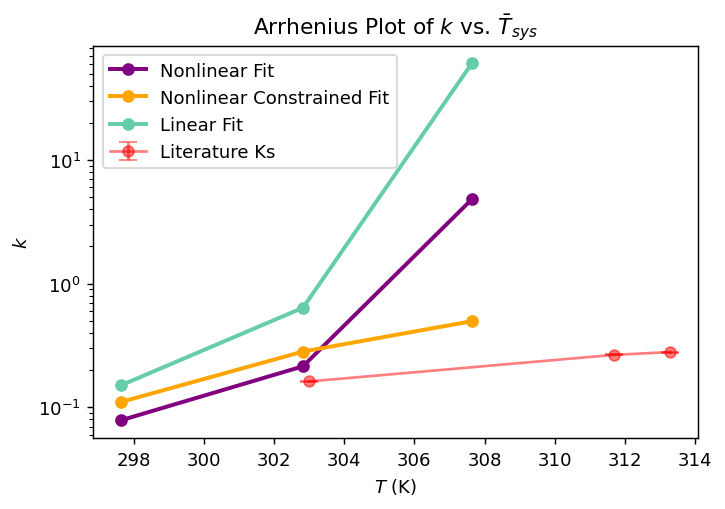

In [51]:
#FIXME: Visualizing the Arrhenius plot of k vs T
#FIXME: need to fix the error bar calculation for the Arrhenius plot
#FIXME: maybe this should be plotted on a log scale?

Temps = np.array([25, 30, 35]) + 273.15
mean_Temps = np.array([np.mean(run1_T), np.mean(run2_T), np.mean(run3_T)])

literature_ks = np.array([1.62e-1, 2.66e-1, 2.80e-1])
literature_Ts = np.array([303, 311.7, 313.3])
literature_errors = np.array([0.009, 0.011, 0.0096])

# Nonlinear and linear fit k errors
ks_nonlin = np.array([params_T1_nonlin[0], params_T2_nonlin[0], params_T3_nonlin[0]])
ks_nonlin_constr = np.array([popt_T1_constr[0], popt_T2_constr[0], popt_T3_constr[0]])
ks_lin = np.array([np.exp(params_T1_lin[1]), np.exp(params_T2_lin[1]), np.exp(z3_trunc[1])])

k_err_lin = np.array([np.exp(conf_T1_lin[1]), np.exp(conf_T2_lin[1]), np.exp(conf_T3_lin_trunc[1])]) # using the 95% confidence interval
k_err_nonlin = np.array([conf_T1_nonlin[0], conf_T2_nonlin[0], conf_T3_nonlin[0]])

# Plotting the Arrhenius plot
plt.plot(mean_Temps, ks_nonlin, color='purple', marker = 'o', linewidth=2.2)
plt.plot(mean_Temps, ks_nonlin_constr, color='orange', marker = 'o', linewidth=2.2)
plt.plot(mean_Temps, ks_lin, color='mediumaquamarine', marker = 'o', linewidth=2.2)
plt.errorbar(literature_Ts, literature_ks, yerr=literature_errors*literature_ks, marker='o', color='red', alpha=0.5, capsize=5)

plt.xlabel(r'$T$ (K)')
plt.ylabel(r'$k$')
plt.yscale('log')
plt.legend(['Nonlinear Fit', 'Nonlinear Constrained Fit', 'Linear Fit', 'Literature Ks'], loc='upper left')
plt.title(r'Arrhenius Plot of $k$ vs. $\bar T_{sys}$')

# print(ks_nonlin)
# print(k_err_nonlin)
# print(ks_lin)
# print(k_err_lin)

ks_markslab = [0.168, 0.272, 0.3634] # from Zach Mark's lab

Given the much greater error in the rate constant for the 35 °C RXN data (as compared with the literature values), we opt to use the 2-point Arrhenius Equation for the first two temperature values to determine the Arrhenius constants for the model reaction.

$$\log(\frac{k(T_1)}{k(T_2)}) = \frac{E_a}{R} (\frac{1}{T_2}-\frac{1}{T_1})$$

We also test an Arrhenius equation curve_fit for the nonlinear constrained fit below.

In [42]:
R = 8.314 # J/mol K

def Arrhenius(T, A, E_a):
    return A * np.exp(-E_a/(R * T))

activation_energy = lambda k1, k2, T1, T2: R * np.log(k1/k2) * (1/T2 - 1/T1)**-1
freq_factor = lambda k, E_a, T: k * np.exp(E_a/(R * T))


# Nonlinear fit
E_a_nonlin_12 = activation_energy(ks_nonlin[0], ks_nonlin[1], mean_Temps[0], mean_Temps[1]) # in J/mol
E_a_nonlin_23 = activation_energy(ks_nonlin[1], ks_nonlin[2], mean_Temps[1], mean_Temps[2])
A_nonlin = freq_factor(ks_nonlin[0], E_a_nonlin_12, mean_Temps[0])

# Linear fit
E_a_lin_12 = activation_energy(ks_lin[0], ks_lin[1], mean_Temps[0], mean_Temps[1])
E_a_lin_23 = activation_energy(ks_lin[1], ks_lin[2], mean_Temps[1], mean_Temps[2])
A_lin = freq_factor(ks_lin[0], E_a_lin_12, mean_Temps[0])

# Constrained fit
E_a_constr_12 = activation_energy(ks_nonlin_constr[0], ks_nonlin_constr[1], mean_Temps[0], mean_Temps[1])
E_a_constr_23 = activation_energy(ks_nonlin_constr[1], ks_nonlin_constr[2], mean_Temps[1], mean_Temps[2])
A_constr = freq_factor(ks_nonlin_constr[0], E_a_constr_23, mean_Temps[0])

# Constrained curve_fit
constr_arrhenius_curvefit = curve_fit(Arrhenius, mean_Temps, ks_nonlin_constr, p0=[A_constr, E_a_constr_23])
popt_constr_curvefit = constr_arrhenius_curvefit[0]
E_a_constr_curvefit = popt_constr_curvefit[1]
A_constr_curvefit = popt_constr_curvefit[0]

print('Nonlinear fit activation energy: %.2f kJ/mol' % (E_a_nonlin_12/1000))
print('Nonlinear fit pre-exponential factor: %.3e' % A_nonlin)
print('\nLinear fit activation energy: %.2f kJ/mol' % (E_a_lin_12/1000))
print('Linear fit pre-exponential factor: %.3e' % A_lin)
print('\nConstrained fit activation energy: %.2f kJ/mol' % (E_a_constr_23/1000))
print('Constrained fit pre-exponential factor: %.3e' % A_constr)

print('\nConstrained fit activation energy (curve_fit): %.2f kJ/mol' % (E_a_constr_curvefit/1000))
print('Constrained fit pre-exponential factor (curve_fit): %.3e' % A_constr_curvefit)



Nonlinear fit activation energy: 145.25 kJ/mol
Nonlinear fit pre-exponential factor: 2.438e+24

Linear fit activation energy: 208.60 kJ/mol
Linear fit pre-exponential factor: 6.154e+35

Constrained fit activation energy: 90.90 kJ/mol
Constrained fit pre-exponential factor: 9.914e+14

Constrained fit activation energy (curve_fit): 103.65 kJ/mol
Constrained fit pre-exponential factor (curve_fit): 2.002e+17


In comparison with the literature activation energy of $E_a$ =  41.4 – 61.4 kJ/mol for this reaction, all of our estimates for the activation energy are much greater. Correspondingly, the frequency factor predictions are also vastly greater. The error in the k measurements can be attributed to batch reaction experimental error (non-constant temperature within runs, imperfect mixing, conductivity and temperature read-out noise, resolution time of conductivity reads, initial concentration accuracy) and analytical error (Conductivity models, interpolation techniques for concentration from conductivity, smoothing techniques, fitting techniques for k, different treatments of temperature fluctuations within runs) with the highest contributing source of error being the fitting techniques for k. For slightly different initial guesses in the nonlinear interpolation, there are large changes in the predicted ks. The tuning of these initial guesses to best reflect the data saw k estimates for many of the temperatures between 0.05 – 500 $M^{-1} s^{-1}$. However the issues in curvature of the less constrained vs constrained fits is likely due to issues with the 35°C experiment as the most accurate constrained fit reflects the data least well.

## Continuous Flow Reactor

In [29]:
# Reading in the CFR data from the xlsx file

# Reading in experimental batch data from excel file
CFR_data = pd.read_excel('Lab 1 Data Clean.xlsx', sheet_name=[3])

CFR_lambda = np.array(CFR_data[3]['Measured \nConductivity \n \n0 - 20 [mS]'])
CFR_T = np.array(CFR_data[3]['Reactor \nTemp. \n \n[°C]']) + 273.15
CFR_nu = np.array(CFR_data[3]['Flowrate \nof Sodium \nHydroxide \n[cm³/min]'])

### 3) Calculating the Volume of CSTR via kinetic parameters and design equation

#### Calculating Concentration to conductivity and temperature data for CSTR

To analyze the conductivity-temperature data for the Continuous Flow Reactor, we update the total interpolation function to reflect the different initial concentrations.

Then, we calculate the Volume of the reaction using the Continuous Flow Reactor design equation
$$ V = \frac{F_{A0}(X_{out} - X_{in})}{(-r_A)_{out}} $$

Where the reaction rate is given by the rate equation, using the fitted constants from the batch reactor:
$$(-r_A)_{out} = k(T) C_A^{\alpha}(X) C_B^{\beta}(X)$$
$$(-r_A)_{out} = k(T) C_A(X)^{\alpha + \beta}$$

And
$$ F_{i0} = C_{i0} \nu $$
With the following initial conditions:

$\nu = (200, 80)$ mL/min

$C_{A0} = C_{B0} = 0.05$ M


In [30]:
# Adjusting the concentration interpolation to account for different enterance concentrations

C_A0_CFR = 0.1/2 # mol/L
X_vec = np.linspace(0,.89,100)
C_a_vec_CFR = C_A0_CFR*(1-X_vec)
C_c_vec_CFR = C_A0_CFR*X_vec

CFR_C_a_vec, CFR_T1_vec  = np.meshgrid(C_a_vec_CFR, exp_Ts)
CFR_C_c_vec, CFR_T2_vec = np.meshgrid(C_c_vec_CFR, exp_Ts)

lambda_1a_CFR = NaOH_interp_C(CFR_T1_vec, CFR_C_a_vec)
lambda_1c_CFR =  NaOAc_interp_C(CFR_T1_vec, CFR_C_c_vec)
lambda_1_CFR = lambda_1a_CFR + lambda_1c_CFR

lambda_1_mat_CFR = []
for i, conds in enumerate(lambda_1_CFR):
    Ts_i = [exp_Ts[i] for j in range(len(conds))]
    lambda_1_mat_CFR.append(np.array([Ts_i, C_A0_CFR*(1-X_vec), conds]))

lambda_1_mat_CFR = np.array(lambda_1_mat_CFR)
new_arr_CFR = np.hstack(lambda_1_mat_CFR).T

tot_points_CFR = new_arr_CFR[:, [0, 2]]  # The first and second columns: temperature and conductivity
tot_values_CFR = new_arr_CFR[:, 1]       # The third column: concentrations

def tot_interp_C_CFR(temperature, conductivity):
    return griddata(tot_points_CFR, tot_values_CFR, (temperature, conductivity), method='cubic', fill_value=0.)


Text(0.5, 1.0, 'Concentration vs. Time for CSTR Data')

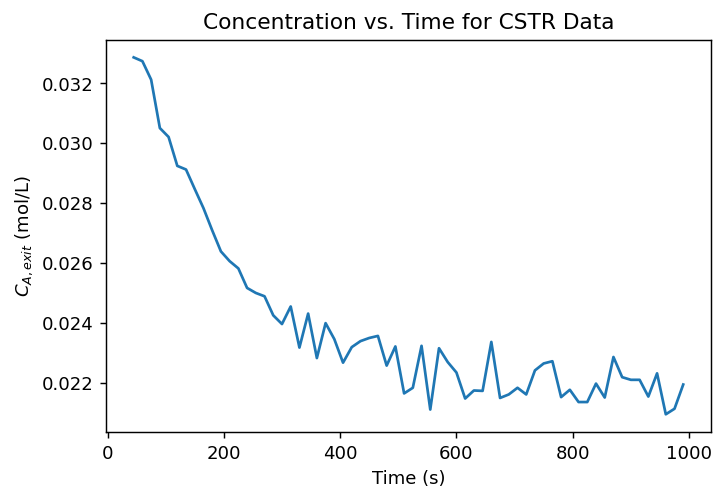

In [31]:
# Plotting the adjusted CFR concentration interpolation

C_a_CFR = tot_interp_C_CFR(CFR_T, CFR_lambda)
time_vec_CFR = np.arange(0, (len(CFR_T))*15, 15)

plt.plot(time_vec_CFR[3:], C_a_CFR[3:])
plt.xlabel('Time (s)')
plt.ylabel(r'$C_{A,exit}$ (mol/L)')
plt.title('Concentration vs. Time for CSTR Data')

Final Conversion = 0.58


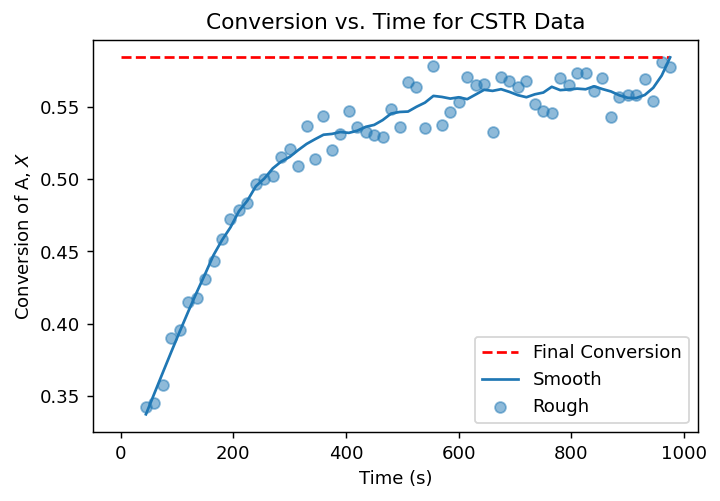

In [35]:
# Visualizing the CFR Conversion vs. Time with smoothing

# smoothing the CFR data
C_a_CFR_smooth = savgol_filter(C_a_CFR[3:-1], 15, 3)

# calculating the conversion from the smoothed data
conversion_CFR_sm = 1 - C_a_CFR_smooth/0.05
conversion_CFR_ro = 1 - C_a_CFR[3:-1]/0.05

plt.hlines(conversion_CFR_sm[-1], 0, time_vec_CFR[-2], color='red', linestyle='--')
plt.plot(time_vec_CFR[3:-1],  conversion_CFR_sm)
plt.scatter(time_vec_CFR[3:-1], conversion_CFR_ro, alpha=0.5)

plt.xlabel('Time (s)')
plt.ylabel(r'Conversion of A, $X$')
plt.legend(['Final Conversion','Smooth', 'Rough'], loc='lower right')
plt.title('Conversion vs. Time for CSTR Data')

print('Final Conversion = %.2f' % conversion_CFR_sm[-1])


In [33]:
# CFR design equation Volume calculation using rate constant fits

# Calculating the molar flowrate of the CFR 
F_A0_f = C_A0_CFR * (2 * CFR_nu[3:-1]) * (1e-3 * 1/60) # mol/s


# Calculating the rate of reaction for CFR using batch data
r_A_CFR_lin_30 = generic_ratelaw_j(0, C_a_CFR[3:-1], np.exp(params_T2_lin[1]), params_T2_lin[0]) # mol/L s
r_A_CFR_nonlin_30 = generic_ratelaw_i(0, C_a_CFR[3:-1], *params_T2_nonlin, C_A0 = 0.05, C_B0 = 0.05) # mol/L s

r_A_CFR_lin_35 = generic_ratelaw_j(0, C_a_CFR[3:-1], np.exp(z3_trunc[1]), z3_trunc[0]) # mol/L s
r_A_CFR_nonlin_35 = generic_ratelaw_i(0, C_a_CFR[3:-1], *params_T3_nonlin, C_A0 = 0.05, C_B0 = 0.05) # mol/L s


# Calculating the volume of the CFR using the design equation
V_CFR_lin_30 = F_A0_f * conversion_CFR_sm / (r_A_CFR_lin_30*-1) # L
V_CFR_nonlin_30 = F_A0_f * conversion_CFR_sm / (r_A_CFR_nonlin_30*-1) # L

V_CFR_lin_35 = F_A0_f * conversion_CFR_sm / (r_A_CFR_lin_35*-1) # L
V_CFR_nonlin_35 = F_A0_f * conversion_CFR_sm / (r_A_CFR_nonlin_35*-1) # L



percent error = 12.58%


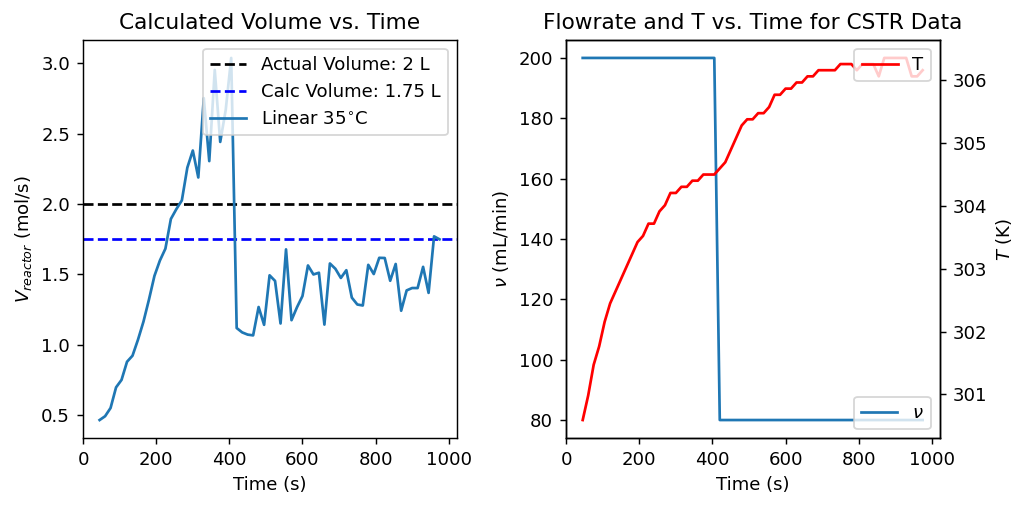

In [34]:
# Plotting the calculated volume of the CFR

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Actual and final predicted volume of the CFR
V_actual = 2
V_final = V_CFR_lin_35[-1]

ax[0].axhline(2, 0, time_vec_CFR[-1], color='k', linestyle='--')
ax[0].axhline(V_final, 0, time_vec_CFR[-1], color='b', linestyle='--')

# Estimated volume of the CFR from conversion and fitted rate constants
ax[0].plot(time_vec_CFR[3:-1], V_CFR_lin_35)
# ax[0].plot(time_vec_CFR[3:-1], V_CFR_nonlin_35)
# ax[0].plot(time_vec_CFR[3:-1], V_CFR_lin_30)
# ax[0].plot(time_vec_CFR[3:-1], V_CFR_nonlin_30)

ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel(r'$V_{reactor}$ (mol/s)')
ax[0].legend(['Actual Volume: 2 L', r'Calc Volume: %.2f L' % V_final, 'Linear 35$^{\circ}$C'], loc='upper right')
ax[0].set_title('Calculated Volume vs. Time')

# Plotting the flowrate and temperature of the CFR
ax2 = ax[1].twinx()

ax[1].plot(time_vec_CFR[3:-1], 2*CFR_nu[3:-1])
ax2.plot(time_vec_CFR[3:-1], CFR_T[3:-1], color='red')

ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel(r'$\nu$ (mL/min)')
ax2.set_ylabel(r'$T$ (K)')

ax[1].legend([r'$\nu$'], loc='lower right')
ax2.legend(['T'], loc='upper right')
ax[1].set_title('Flowrate and T vs. Time for CSTR Data')

plt.tight_layout()

percent_err = lambda x, y: np.abs(x - y)/y * 100

print('percent error = %.2f' % percent_err(V_final, V_actual) + '%')

### 5) Additional method to determine rate constant and reaction order

Another method to determine the rate constant and reaction order would be the initial rates method. You would run the batch reactor for more than 5 separate equimolar initial concentrations of A and B (at the same temperature) to find the reaction order and rate constant. This method is elucidated through the initial reaction rate equation turned into a linear regression problem, $$-r_{A0} = -\frac{dC_{A0}}{dt} = k C_{A0}^{\alpha + \beta} \Rightarrow \log(-\frac{dC_{A0}}{dt}) = \log(k) + (\alpha + \beta)\log(C_{A0})$$

The exponential of the y-intercept would be the rate constant for the operating T, and the slope would be the reaction order. It is important to note the use of equimolar initial concentrations of A and B so both reaction orders can be combined in the $C_{A0}$ term (also note the assumption that k is constant for constant temperature reactions).

Then, to observe the k vs T relationship, you would measure the different ks according to the previously observed rate of reaction for various temperatures while holding the initial concentrations constant. Then one would fit the k vs T data to the Arrhenius equation to derive the relationship between k and T. This assumes that k is due to a single rate determining step and thus can be modelled like an elementary step.

$$ k(T) = A\exp(-\frac{E_A}{RT}) $$

### 6) Reaction Mechanism: mechanism and intermediats, rate of formation, rate of consumption of EtOAc

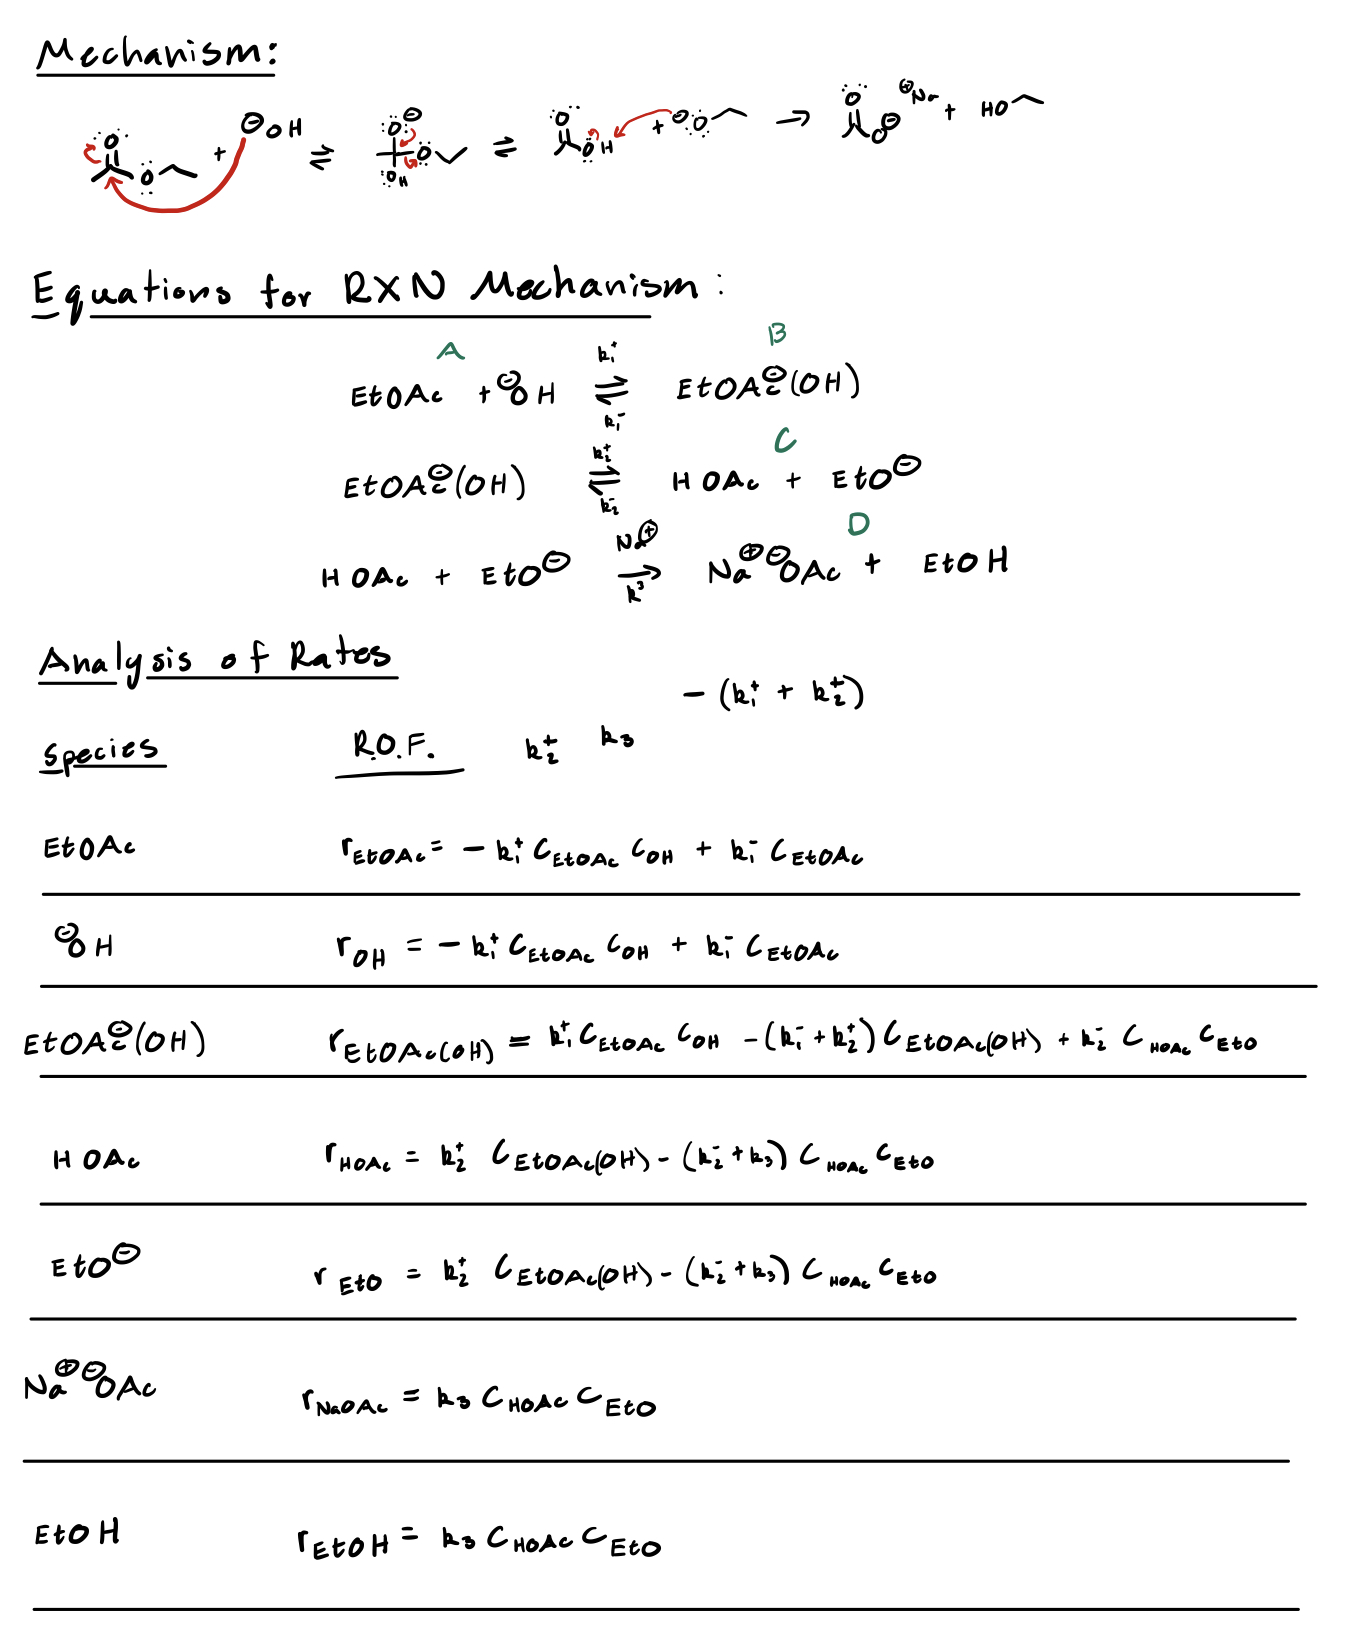

In [45]:
Image('./IMG_B4B55492914E-1.jpeg')

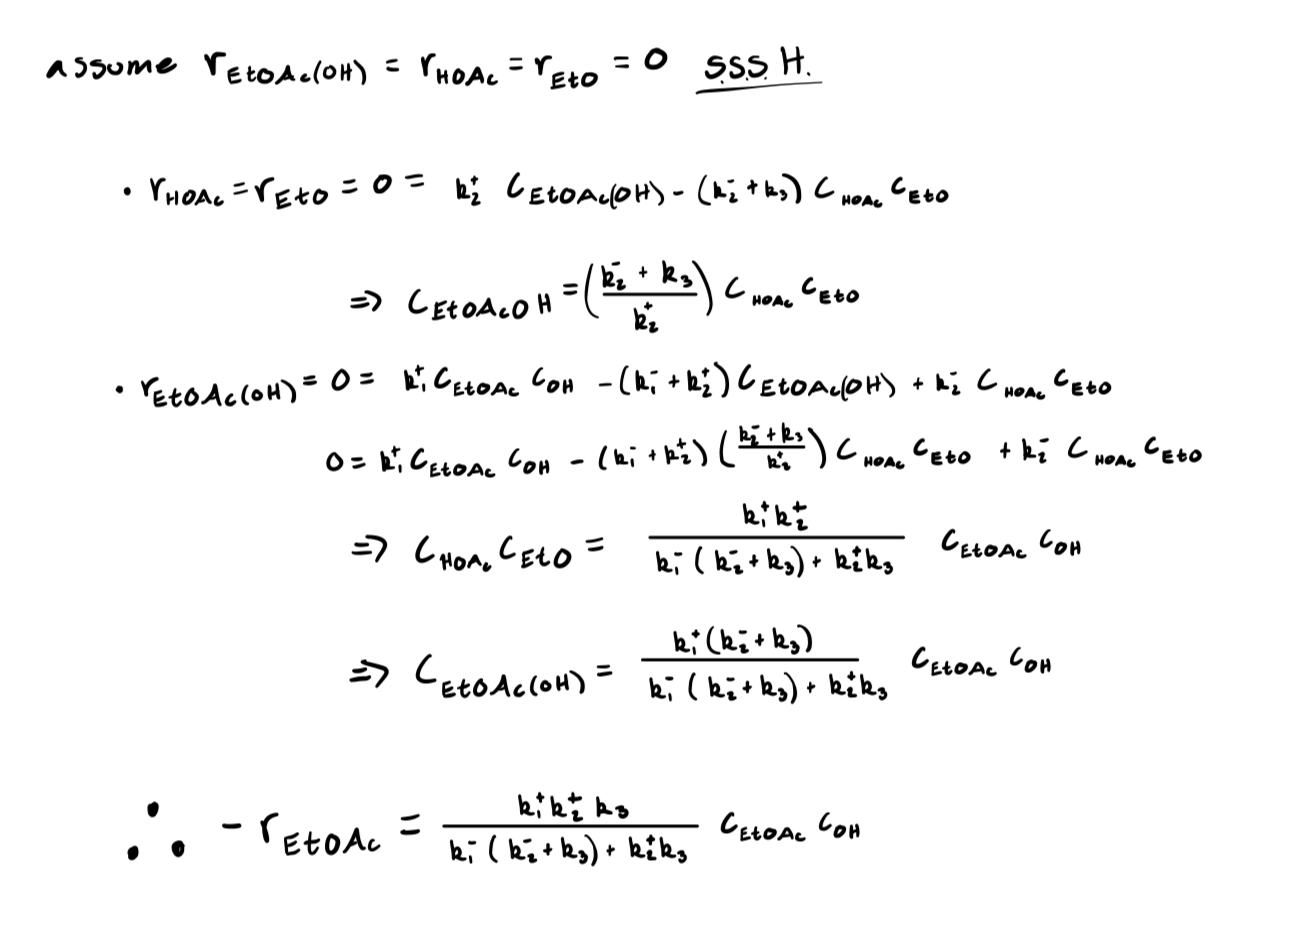

In [46]:
Image('./IMG_EE26F38CFE38-1.jpeg')